# Conditional VAE


## Library imports
The following code contains the required libraries for the notebook.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

#import ...
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

>> Using device: cuda:0


## Fashion MNIST

In [33]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from functools import reduce


classes = [0, 1, 2]
batch_size = 64
eval_batch_size = 64

# transforms into tensor, can be extend
transformations = transforms.Compose([transforms.ToTensor()]) 


# Define the train and test sets
dset_train = FashionMNIST("./", train=True,  transform=transformations, download=True)
dset_test  = FashionMNIST("./", train=False, transform=transformations)


def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# load the datasets into DataLoader classes, sampler removed!
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


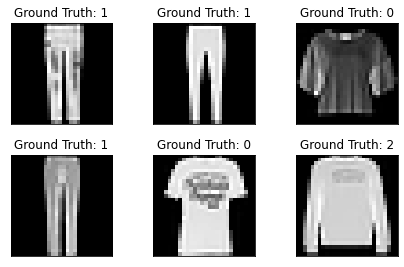

In [34]:
# https://nextjournal.com/gkoehler/pytorch-mnist
# Print from testset
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

plt.show()

## The Model 

inspired by: https://www.kaggle.com/ethanwharris/fashion-mnist-vae-with-pytorch-and-torchbearer

In [35]:
#https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss
    KLD = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KLD

In [36]:
#Settings
latent_size = 15
learning_rate = 1e-3
num_epochs = 5

In [104]:
conv1 = (1, 32, 4, 1, 2)
conv2 = (conv1[1], 32, 4, 2, 1)
conv3 = (conv2[1], 64, 4, 2, 1)


##Look at 7.2 to see how to make encoder and decoder take non-fixed size image. 

class VariationalAutoEncoder(nn.Module):
    def __init__(self, latent_size):
        super(VariationalAutoEncoder,self).__init__()
        self.latent_size = latent_size
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=conv1[0],out_channels=conv1[1],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv2[0],out_channels=conv2[1],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4]),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=conv3[0],out_channels=conv3[1],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=conv3[1],out_channels=conv3[0],kernel_size=conv3[2],stride=conv3[3],padding=conv3[4]),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv2[1],out_channels=conv2[0],kernel_size=conv2[2],stride=conv2[3],padding=conv2[4],output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=conv1[1],out_channels=conv1[0],kernel_size=conv1[2],stride=conv1[3],padding=conv1[4]),
            )
        
        self.mu = nn.Linear((64 * 7 * 7)+1, latent_size) # +1 for class label
        self.logvar = nn.Linear((64 * 7 * 7)+1, latent_size) # +1 for class label
        self.upsample = nn.Linear(latent_size+1, 64 * 7 * 7)
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)


    def generate(self, t):
      z = torch.randn(self.latent_size).to(device)
      z = torch.cat((z, t), dim=-1)
      z = self.upsample(z)
      z = z.view(-1,64,7,7)
      z = self.decoder(z)
      return z

    # https://debuggercafe.com/getting-started-with-variational-autoencoder-using-pytorch/    
    def forward(self, x, t):
        # encoding
        x = self.encoder(x)
        x = x.view(-1,64*7*7) # flatten
        t = t.view(-1, 1)
        x = torch.cat((x,t), dim=-1)
        
        mu = self.mu(x)
        log_var = self.logvar(x)
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        # decoding
        z = torch.cat((z, t), dim=-1)
        z = self.upsample(z)

        z = z.view(-1,64,7,7)
        
        x = self.decoder(z)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction, mu, log_var


vae = VariationalAutoEncoder(latent_size)
print(vae)

# Test implementation
vae.to(device)
x, y = example_data[:2].to(device), example_targets[:2].to(device)
vae(x, y)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
  (mu): Linear(in_features=3137, out_features=15, bias=True)
  (logvar): Linear(in_features=3137, out_features=15, bias=True)
  (upsample): Linear(in_features=16, out_features=3136, bias=True)
)


(tensor([[[[0.4667, 0.4445, 0.4581,  ..., 0.4634, 0.4517, 0.4579],
           [0.4686, 0.4794, 0.4454,  ..., 0.4530, 0.4662, 0.4560],
           [0.4880, 0.4335, 0.4319,  ..., 0.4714, 0.4409, 0.4570],
           ...,
           [0.4689, 0.4438, 0.4697,  ..., 0.4402, 0.4683, 0.4443],
           [0.4642, 0.4630, 0.4538,  ..., 0.4634, 0.4651, 0.4635],
           [0.4791, 0.4572, 0.4518,  ..., 0.4402, 0.4567, 0.4539]]],
 
 
         [[[0.4700, 0.4387, 0.4464,  ..., 0.4676, 0.4529, 0.4623],
           [0.4831, 0.4717, 0.4683,  ..., 0.4553, 0.4583, 0.4663],
           [0.4568, 0.4574, 0.4637,  ..., 0.4378, 0.4479, 0.4567],
           ...,
           [0.4913, 0.4589, 0.4500,  ..., 0.4412, 0.4657, 0.4464],
           [0.4853, 0.4611, 0.4568,  ..., 0.4814, 0.4677, 0.4592],
           [0.4775, 0.4652, 0.4614,  ..., 0.4439, 0.4531, 0.4548]]]],
        device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[-0.0409,  0.0114, -0.0025,  0.0214,  0.0202,  0.0414,  0.0092,  0.0127,
           0.0102, -

### KL

### Visualisation

### Training

In [105]:
vae = VariationalAutoEncoder(latent_size=latent_size)
optimizer = optim.Adam(vae.parameters(),lr=learning_rate)
criterion = nn.BCELoss(reduction='sum')


In [106]:
def fit_vae(vae, train_loader):
    vae.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for x, y in train_loader:
        # x.view?
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = vae(x, y)
        bce_loss = criterion(reconstruction, x)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(train_loader.dataset)
    return train_loss

def test_vae(vae, test_loader):
    vae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            # x.view?
            x = x.to(device)
            y = y.to(device)
            reconstruction, mu, logvar = vae(x, y)
            bce_loss = criterion(reconstruction, x)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            
    val_loss = running_loss/len(test_loader.dataset)
    return val_loss
            

In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")
vae = vae.to(device)

##
train_loss = []
test_loss = []
num_epochs = 30

for current_epoch in range(num_epochs):
    print(f"Epoch {current_epoch+1} of {num_epochs}")
    train_epoch_loss = fit_vae(vae, train_loader)
    test_epoch_loss = test_vae(vae, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")
    

>> Using device: cuda:0
Epoch 1 of 30
Train Loss: 73.7556
Val Loss: 74.7464
Epoch 2 of 30
Train Loss: 73.5794
Val Loss: 74.5093
Epoch 3 of 30
Train Loss: 73.4230
Val Loss: 74.4837
Epoch 4 of 30
Train Loss: 73.3718
Val Loss: 74.4783
Epoch 5 of 30
Train Loss: 73.2382
Val Loss: 74.6078
Epoch 6 of 30
Train Loss: 73.1791
Val Loss: 74.1511
Epoch 7 of 30
Train Loss: 73.0883
Val Loss: 74.1583
Epoch 8 of 30
Train Loss: 73.0158
Val Loss: 74.1282
Epoch 9 of 30
Train Loss: 72.9430
Val Loss: 73.9721
Epoch 10 of 30
Train Loss: 72.9282
Val Loss: 73.9880
Epoch 11 of 30
Train Loss: 72.8769
Val Loss: 74.1768
Epoch 12 of 30
Train Loss: 72.8127
Val Loss: 73.8836
Epoch 13 of 30
Train Loss: 72.7715
Val Loss: 73.7985
Epoch 14 of 30
Train Loss: 72.7267
Val Loss: 73.8021
Epoch 15 of 30
Train Loss: 72.6905
Val Loss: 73.9002
Epoch 16 of 30
Train Loss: 72.6537
Val Loss: 73.9992
Epoch 17 of 30
Train Loss: 72.6516
Val Loss: 73.7563
Epoch 18 of 30
Train Loss: 72.6126
Val Loss: 73.7384
Epoch 19 of 30
Train Loss: 72.5

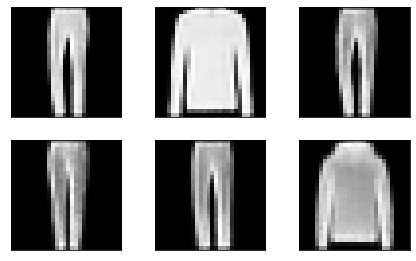

In [128]:
# examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output,_,_ = vae(example_data.to(device), example_targets.to(device))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(output.cpu()[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
fig.show()

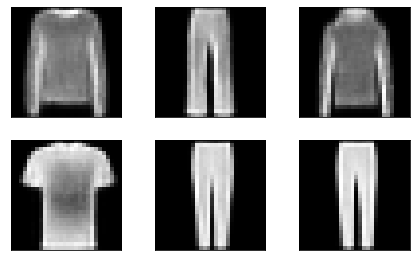

In [129]:
# examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output,_,_ = vae(example_data.to(device), example_targets.to(device))

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(output.cpu()[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
fig.show()

torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])
torch.Size([15])
torch.Size([1])


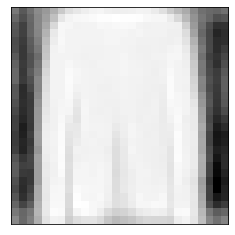

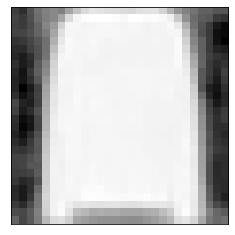

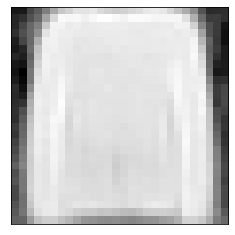

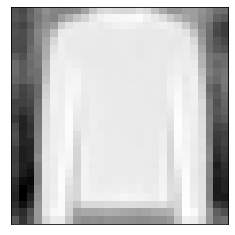

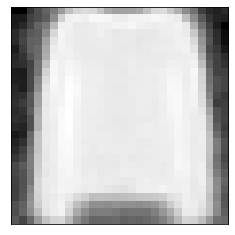

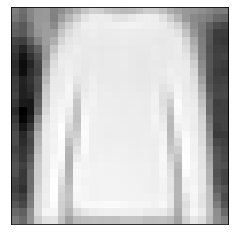

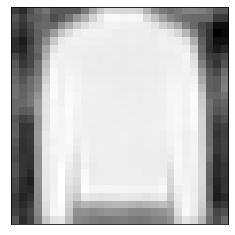

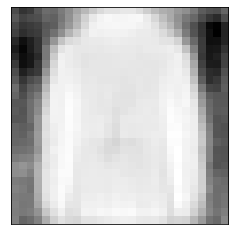

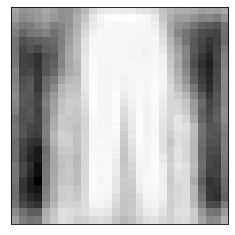

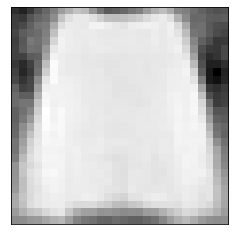

In [131]:
for i in range(10):
  with torch.no_grad():
    target = torch.tensor([2]).to(device) # 0 for t-shirt, 1 for trouser, 2 for pullover
    out = vae.generate(target)

  fig = plt.figure()
  plt.imshow(out.cpu()[0][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

  fig.show()